In [57]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [58]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [59]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [60]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
#ripped the inspector lines off of dates_solution, greatly assists in creating queries since human needs shape of db
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [61]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [62]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [63]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Precipitation Analysis

In [64]:
# Find the most recent date in the data set.
date = session.query(measurement).order_by(measurement.date.desc()).first().date
date

'2017-08-23'

<Axes: xlabel='Date', ylabel='Inches'>

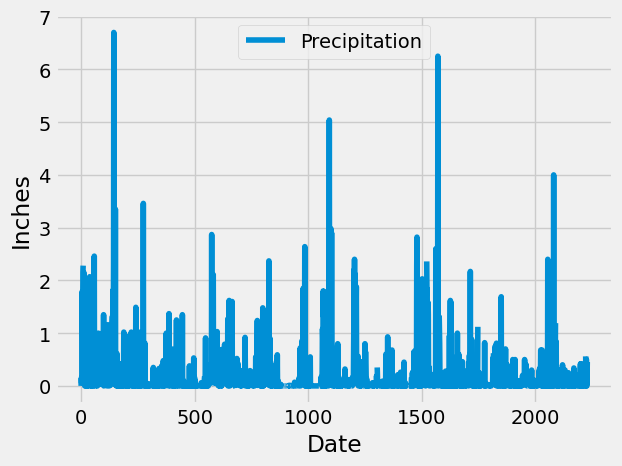

In [96]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
datelist = list(date)
datelist[3] = str(int(date[3])-1)
datenew = ''.join(datelist)
# Perform a query to retrieve the data and precipitation scores
data = session.query(measurement.date).filter(measurement.date >= datenew).order_by(measurement.date).all()
data2 = session.query(measurement.prcp).filter(measurement.date >= datenew).order_by(measurement.date).all()

# for some ungodly reason, these queries return extra information in the form of (data, ) in them
# this nifty little line removes that courtesy of stackexchange
# check readme for source
data1 = [r for (r, ) in data]
data21 = [r for (r,) in data2]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_df = pd.DataFrame(list(zip(data1,data21)),columns =['Date','Precipitation'])
# turns out that the final query doesn't remove NA. What does NaN numbers even mean in this dataset, given there are zeroes?
#rain_df['Precipitation'] = rain_df['Precipitation'].fillna(0)

# Sort the dataframe by date
rain_df.sort_values(by='Date',ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
# This plot WAS hell until I didn't pass it a type. What? It's missing the legend and dates, but, oh well.
rain_df.plot(y='Precipitation',ylabel="Inches",xlabel="Date")


In [66]:
# Use Pandas to calculate the summary statistics for the precipitation data
# there was a moment in which this did not return the correct data - in reality, I used just > instead of >= in the query above, which is apparently what the example did
# I'm going to willfully ignore the fact this returns 366 days of data, but, hey, that's just me
rain_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [67]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()


[(9,)]

In [68]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
beststation = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
beststation
# this is the bestest station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [69]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == beststation[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

<Axes: xlabel='Temperature', ylabel='Frequency'>

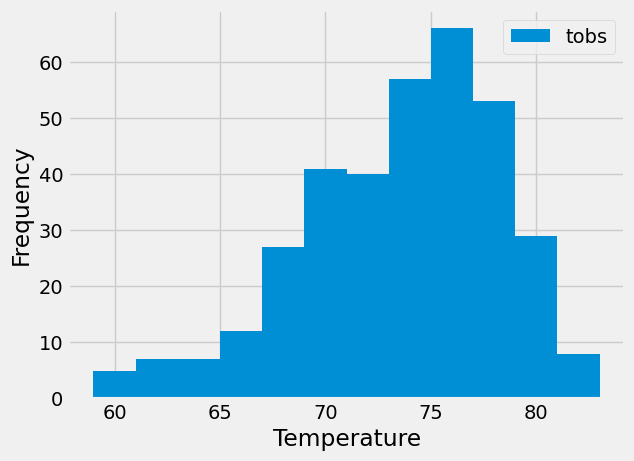

In [97]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data2 = session.query(measurement.date).filter(measurement.date >= datenew).filter(measurement.station == beststation[0][0]).order_by(measurement.date).all()
data22 = session.query(measurement.tobs).filter(measurement.date >= datenew).filter(measurement.station == beststation[0][0]).order_by(measurement.date).all()

# we add a two on the end of all the data logic above, and then filter by beststation, and then easy win
data21 = [r for (r, ) in data2]
data221 = [r for (r,) in data22]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_df = pd.DataFrame(list(zip(data21,data221)),columns =['Date','tobs'])

# Sort the dataframe by date
rain_df.sort_values(by='Date',ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
# this plot just worked. I enjoy
rain_df.plot(kind="hist",ylabel="Frequency",xlabel="Temperature",bins=12)

# Close Session

In [71]:
# Close Session
session.close()